Now, we will take attempt to classify the ASL MNIST dataset observations using a clustering technique: K-Means.

In [12]:
# Common imports from Assignment - 2, plus some additional. 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [13]:
# Loading the data. 
train_data_path = 'data/sign_mnist_train.csv'
test_data_path = 'data/sign_mnist_test.csv'

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

# Displaying the first few rows for sanity check. 
train_df.head(), train_df.shape, test_df.shape

(   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
 0      3     107     118     127     134     139     143     146     150   
 1      6     155     157     156     156     156     157     156     158   
 2      2     187     188     188     187     187     186     187     188   
 3      2     211     211     212     212     211     210     211     210   
 4     13     164     167     170     172     176     179     180     184   
 
    pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
 0     153  ...       207       207       207       207       206       206   
 1     158  ...        69       149       128        87        94       163   
 2     187  ...       202       201       200       199       198       199   
 3     210  ...       235       234       233       231       230       226   
 4     185  ...        92       105       105       108       133       163   
 
    pixel781  pixel782  pixel783  pixel784  
 0       206   

In [14]:
# Preparing the data for clustering by excluding the first 'label' column
X_train = train_df.drop('label', axis=1).values
X_test = test_df.drop('label', axis=1).values

In [15]:
# Normalizing the dataset 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Picking the right K
## Elbow Method

Now, before we get into K-Mean clustering, we will find out what will be a good value to pick for k for efficient clustering for our dataset. We will utilise the Elbow method to evaluate this which involves plotting the sum of squared distances of samples to their closest cluster centre for a range of k values and looking for the "elbow" point where the rate of decrease sharply changes. Interestingly, from this possible value of K only, we will get a good idea if K-Means clustering is a good classification technique!

/Users/sakshamrai/Desktop/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sakshamrai/Desktop/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sakshamrai/Desktop/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sakshamrai/Desktop/anaconda3/envs/COGS118B_WI24/

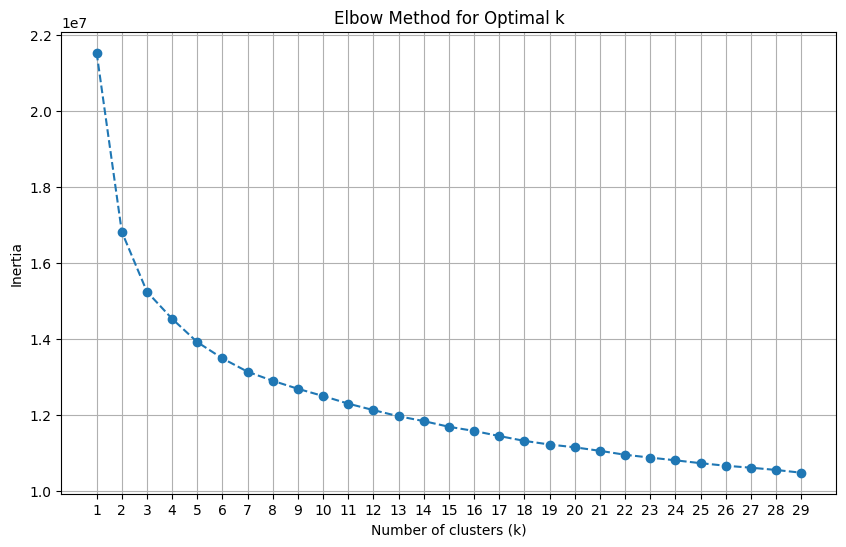

In [16]:
inertia = []
k_range = range(1, 30)  # Note we have 24 distinct letter classes in the ASL MNIST dataset. 
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

The elbow method graph suggests an optimal number of clusters at around k=4 for the dataset based on the rate of decrease in inertia; however, this choice of k is not ideal for our ASL MNIST dataset, which has 24 distinct classes. Choosing a k value of 10 would result in under-clustering, where multiple distinct ASL signs might be forced into the same cluster, leading to a loss of critical classification detail necessary for accurately distinguishing all the unique ASL characters. Therefore, aligning the number of clusters with the number of actual classes in the dataset is more appropriate for classification tasks aiming for high accuracy. 
So we proceed with our clustering using k = 24.

# Cluster Visualizations 

/Users/sakshamrai/Desktop/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


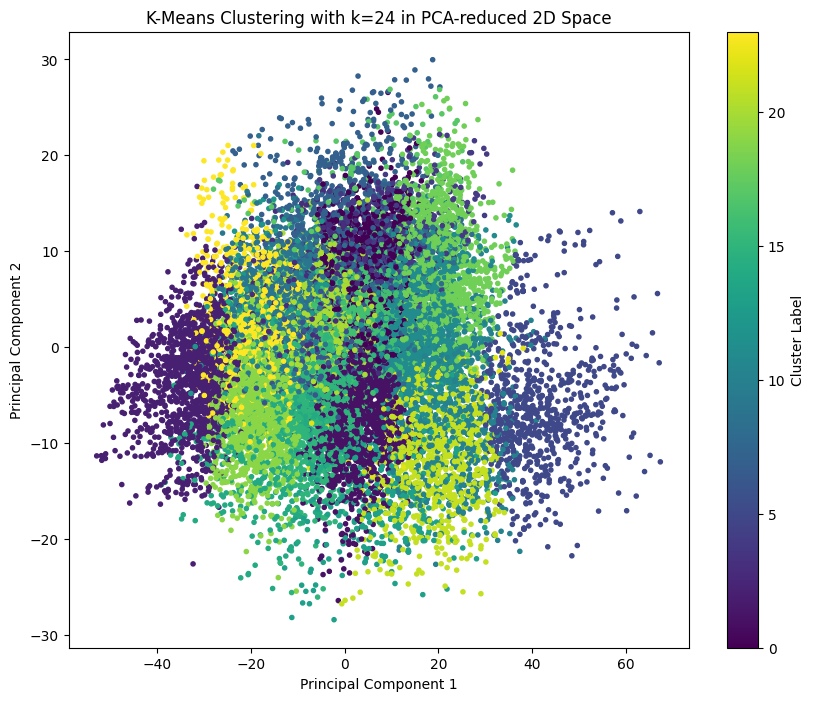

In [20]:
# Step 1: K-Means Clustering with k=24
kmeans_k24 = KMeans(n_clusters=24, init='k-means++', random_state=42)
kmeans_k24.fit(X_train_scaled)

# Step 2: Dimensionality Reduction with PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting
X_train_pca = pca.fit_transform(X_train_scaled)

# Step 3: Visualization
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_k24.labels_, cmap='viridis', marker='.')
plt.title('K-Means Clustering with k=24 in PCA-reduced 2D Space')
plt.colorbar(label='Cluster Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

The clusters are not distinctly separated, indicating a considerable overlap in the PCA-reduced feature space. This overlap suggests that while K-Means has identified clusters, the reduction in dimensions may have resulted in the loss of significant features that differentiate the ASL characters, affecting the efficacy of classification. Since PCA aims to preserve global structure at the expense of local details, the visual similarity of some ASL signs could be responsible for the observed blending of clusters. The dense central region implies that many signs share common variance in the most significant principal components. 

# Model Efficiency 
Now to evaluate the performance of our model, we will utilise the two most common evaluation metrics for K-Means clustering: Silhouette Score and Adjusted Rand Index, primarily because:

1. Cluster Cohesion and Separation: It quantitatively measures how similar each data point is to its own cluster compared to other clusters, providing insight into the effectiveness of the clustering in terms of cohesion and separation.
2. No Need for True Labels: Useful for evaluating the quality of clustering without relying on the ground truth labels, making it versatile for unsupervised learning scenarios.
3. Ground Truth Comparison: Since your dataset has true labels (the correct sign language letter for each image), ARI allows you to compare the clustering results directly against these true labels, giving a measure of the clustering accuracy.
4. Chance Adjustment: ARI adjusts for the chance grouping of data points, offering a more accurate assessment of the clustering performance than raw metrics like the Rand Index.

In [19]:
labels_pred = kmeans_k24.labels_

# true labels from the dataset
labels_true = train_df['label'].values

# Silhouette Score
silhouette_avg = silhouette_score(X_train_scaled, labels_pred)
print(f'Silhouette Score: {silhouette_avg:.4f}')

# Adjusted Rand Index
ari_score = adjusted_rand_score(labels_true, labels_pred)
print(f'Adjusted Rand Index: {ari_score:.4f}')

Silhouette Score: 0.0600
Adjusted Rand Index: 0.0708


The silhouette score and adjusted Rand index (ARI) for our K-Means clustering algorithm applied to the ASL MNIST dataset have yielded scores of 0.0600 and 0.0708, respectively. These results suggest that the K-Means algorithm, under its current configuration and with the given feature space, has limited effectiveness in distinguishing the ASL characters distinctly. A silhouette score close to 0 indicates overlapping clusters with no clear distinction, while the ARI, slightly above 0, shows minimal agreement between the K-Means assigned clusters and the true ASL labels.